# Roundoff error

The error formulas derived by series expansions are known as **truncation error**. In standard methods, these have a leading term that is $O(h^p)$ for a positive integer $p$. There is another source of error, however, due to **roundoff**.

## Subtractive cancellation 

Recall that every value and basic operation is represented in the computer up to a relative accuracy of $\epsm$, known as **machine epsilon**. In the default double precision, 

$$
\epsm = 2^{-52} \approx 2 \times 10^{-16},
$$

and we generally say "16 digits of precision" are available. This is usually not an issue---except with certain operations.

Consider the problem $x - (x-\delta)$. Each operand is represented in the computer by the values

$$
\text{fl}(x) = x(1+\epsilon_1), \quad \text{fl}(x-\delta) = (x-\delta)(1+\epsilon_2),
$$

where each $|\epsilon_i| < \epsm$. Let's say we are lucky and the subtraction is performed *exactly*:

$$
\text{fl}(x) - \text{fl}(x-\delta) = (\epsilon_1-\epsilon_2)x + \delta \epsilon_2. 
$$

We find the relative accuracy of the result is 

$$
\frac{\left[\text{fl}(x) - \text{fl}(x-\delta)\right] - \delta}{\delta} = \epsilon_2 + (\epsilon_1-\epsilon_2)\frac{x}{\delta}. 
$$

The first term is as we would hope, but the second will be troublesome if $|x| \gg |\delta|$. In fact, the relative error can be amplified by their ratio in passing from data to result, and we call this the **condition number** of the subtraction problem.
This is the phenomenon of **subtractive cancellation**.

In [1]:
using PrettyTables
δ = @. 1/10^(2:13)
x = 3.1416
d = @. x - (x-δ) 
err = @. abs(d-δ) / δ
pretty_table([δ d err x*eps()./δ],header=["δ","result","rel. error","bound"])

┌─────────┬─────────────┬─────────────┬─────────────┐
│       δ │      result │  rel. error │       bound │
├─────────┼─────────────┼─────────────┼─────────────┤
│    0.01 │        0.01 │ 2.13371e-14 │ 6.97575e-14 │
│   0.001 │       0.001 │ 1.10155e-13 │ 6.97575e-13 │
│  0.0001 │      0.0001 │ 2.11026e-12 │ 6.97575e-12 │
│  1.0e-5 │      1.0e-5 │ 6.55112e-12 │ 6.97575e-11 │
│  1.0e-6 │      1.0e-6 │ 1.39778e-10 │ 6.97575e-10 │
│  1.0e-7 │      1.0e-7 │  1.63658e-9 │  6.97575e-9 │
│  1.0e-8 │      1.0e-8 │  6.07747e-9 │  6.97575e-8 │
│  1.0e-9 │      1.0e-9 │  8.27404e-8 │  6.97575e-7 │
│ 1.0e-10 │     1.0e-10 │  8.27404e-8 │  6.97575e-6 │
│ 1.0e-11 │     1.0e-11 │  8.27404e-8 │  6.97575e-5 │
│ 1.0e-12 │ 1.00009e-12 │  8.89006e-5 │ 0.000697575 │
│ 1.0e-13 │ 9.99201e-14 │ 0.000799278 │  0.00697575 │
└─────────┴─────────────┴─────────────┴─────────────┘


## Optimal accuracy of a FD formula

Consider the humble forward-difference formula on 2 points,

$$
\frac{u(h)-u(0)}{h}. 
$$

As $h\to 0$, the values in the numerator get closer together. Since the numerator is approximately $hu'(0)$, the condition number of the operation is about $u(0)/hu'(0)$, which grows without bound as $h\to 0$. So the computed result for $u'(0)$ will have errors

$$
E_1(h) \approx c_1 h + c_2 h^{-1}\epsm .
$$

The total will be minimized when both contributions in the sum are equal:

$$
c_1 h \approx c_2 h^{-1}\epsm \quad \Rightarrow \quad h_* = O(\epsm^{1/2}), 
$$

and the optimal error is 

$$
E_1(h_*) = O(h_*) = O(\epsm^{1/2}). 
$$

That is, we can never get better than about 8 digits of accuracy in the result.

In general, the total error for a $p$-th order formula is 

$$
E_p(h) \approx c_1 h^p + c_2 h^{-1}\epsm .
$$

The optimal error satisfies 

$$
c_1 h^p & \approx c_2 h^{-1}\epsm \quad \Rightarrow \quad h_* = O(\epsm^{1/(p+1)}), \\
E_p(h_*) &= O(h_*^p) = O(\epsm^{p/(p+1)}).
$$

As the order increases, we get a larger optimal $h_*$ (and therefore fewer total nodes over a fixed interval), and the result has a fraction $p/(1+p)$ of the original accurate digits. For $p=4$, for example, this implies a tad less than 13 digits.

Here's a computation of the total errors in 1st- and 2nd-order formulas.

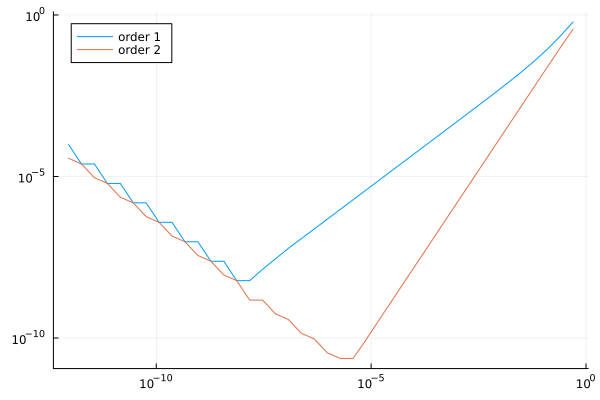

In [2]:
f(x) = sin(2.1x)+cos(x)
exact = 2.1
h = [1/2^n for n in 1:40]
FD1err = []
FD2err = []
for h in h
    FD1 = (f(h)-f(0))/h
    FD2 = (f(h)-f(-h))/2h
    push!(FD1err,abs(FD1-exact))    
    push!(FD2err,abs(FD2-exact))
end

using Plots
plot(h,[FD1err FD2err],
    xaxis=:log10,yaxis=:log10,label=["order 1" "order 2"],leg=:topleft)

On the right side of the graph above, you see convergence with slopes 1 and 2. But this is eventually dominated by the effect of roundoff, which shows up as a slope of -1.

## Instability?

Should we be looking for a different method to compute derivatives? Consider the abstract problem of mapping a function to its derivative at zero: $ u \mapsto u'(0)$. If we perturb $u$ by a function $\delta v(x)$, then the relative error in computing the derivative exactly is 

$$
\frac{\delta v'(0)}{u'(0)}. 
$$

We don't really have much control over what $v$ is. Formally, there is no upper bound if we maximize the ratio over all differentiable functions; in functional analysis, differentiation is an unbounded operator.

In numerical practice, $v$ is a rather noisy function, so we expect the upper bound to be large. Differentiation is an inherently ill-conditioned problem, and there's no accurate algorithm that can cure that. Fortunately, solving differential equations is *not* necessarily ill-conditioned, and FD is a valid way to get results almost as accurately as can be expected, provided we use higher-order methods.